# Классификация текста

Сидоров Александр, Казюлина Марина

In [1]:
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 1. EDA - анализ данных

  - показать разные статистики для ваших данных
  - визуализировать данные
  - очистить от мусора
  - новые фичи, которые вы придумаете (попробовать повыделять разные фичи, которые мы в теории прошли на паре)
  - какие-нибудь интересные методы, которые вы придумаете

В данной работе используется датасет [Tweets](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset)

Данные содержат 27.5 тысячи твитов вместе с лейблом, указывающим на эмоциональную окраску: позитивный, негативный, нейтральный.

Колонки:
* textID - уникальный идентификатор
* text - содержание твита
* sentiment - лейбл категории эмоциональной окраски
* selected_text - наиболее значимые слова в твите, указывающие на эмоцию

Последняя колонка слишком сильно упрощает задачу, поэтому ее использование при обучении моделей рассмотрено не будет.

### Загрузка данных

In [2]:
data = pd.read_csv("Tweets.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
data.drop(columns=['textID', 'selected_text'], inplace=True)
data = data.dropna(axis=0).reset_index(drop=True)
data.describe()

,text,sentiment
count,27480,27480
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11117


Видим, что качество датасета высокое: отсутствуют дубликаты и пропущенные значения.

### Разделение на тренировочную и тестовую выборку

Используем factorize, чтобы сохранить изначальное распределение классов.

In [4]:
y_factorized, class_names = pd.factorize(data['sentiment'], sort=True)
train_data, test_data = train_test_split(data, stratify=y_factorized, random_state=42)
print('Unique classes:', *class_names)

Unique classes: negative neutral positive


### Баланс классов

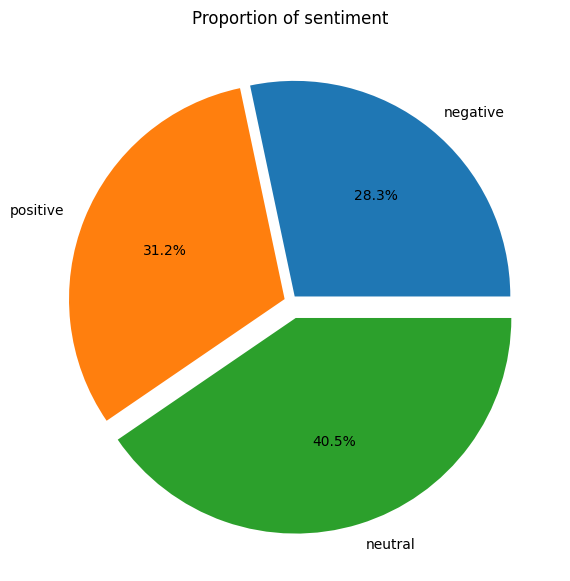

In [5]:
x = train_data.sentiment.value_counts().sort_values()

plt.figure(figsize=(7, 7))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Proportion of sentiment')

plt.show()

### Облако слов

Отобразим распределение самых часто встречающихся слов по классам. Не будем учитывать стоп слова и самые часто встречающиеся слова в датасете (чьё количество превышает 99.5 перцентиль)

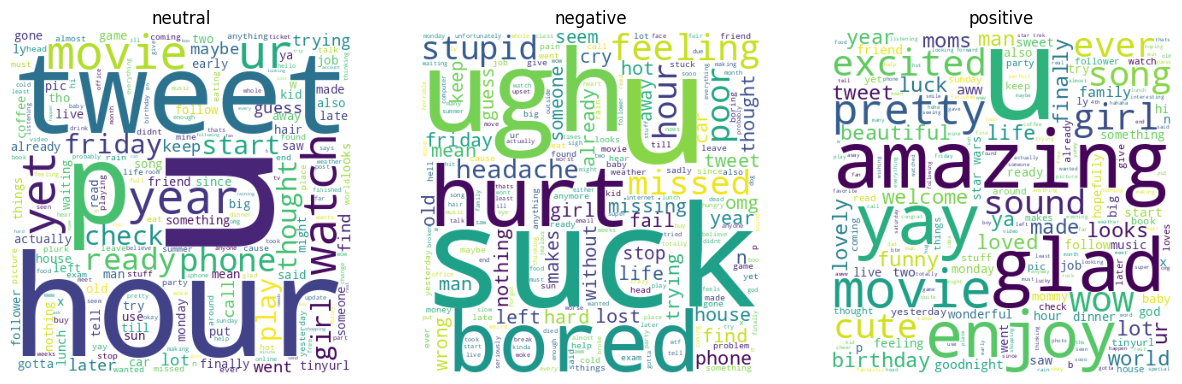

In [6]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

stop_words = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stop_words)
word_counts = np.asarray(vectorizer.fit_transform(train_data['text']).sum(0)).squeeze()

percentil_99 = np.percentile(word_counts, 99.5)
most_freq_inds = np.nonzero(word_counts > percentil_99)[0]

w2i_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

for ind in most_freq_inds:
    stop_words.append(w2i_vocab[ind])

stop_words = set(stop_words)
classes = train_data['sentiment'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
for i, cls in enumerate(classes):
    cls_data = train_data[train_data['sentiment'] == cls]['text']
    cls_str = ' '.join(cls_data.to_list()).lower()
    cloud = WordCloud(stopwords=stop_words, height=400, background_color='white').generate(cls_str)
    axes[i].imshow(cloud)
    axes[i].set_title(cls)
    axes[i].axis("off")

plt.show()

Как можно видеть, распределение самых частых слов отличается в зависимости от класса. По многим из этих слов можно сразу понять, к какому классу принадлежит твит.

### Распределение по длине

Подсчитаем различные статистики, связанные с длиной.
В них входит длина текста в словах и в символах, а также плотность слов -- то есть какова средняя длина слов.

Существуют теории, что языковая экспликация печали связана с более длинными выражениями. Подтвердят ли это наши данные?

Минимальная длина: 1 токенов, 3 символов.
Максимальная длина: 106 токенов, 141 символов


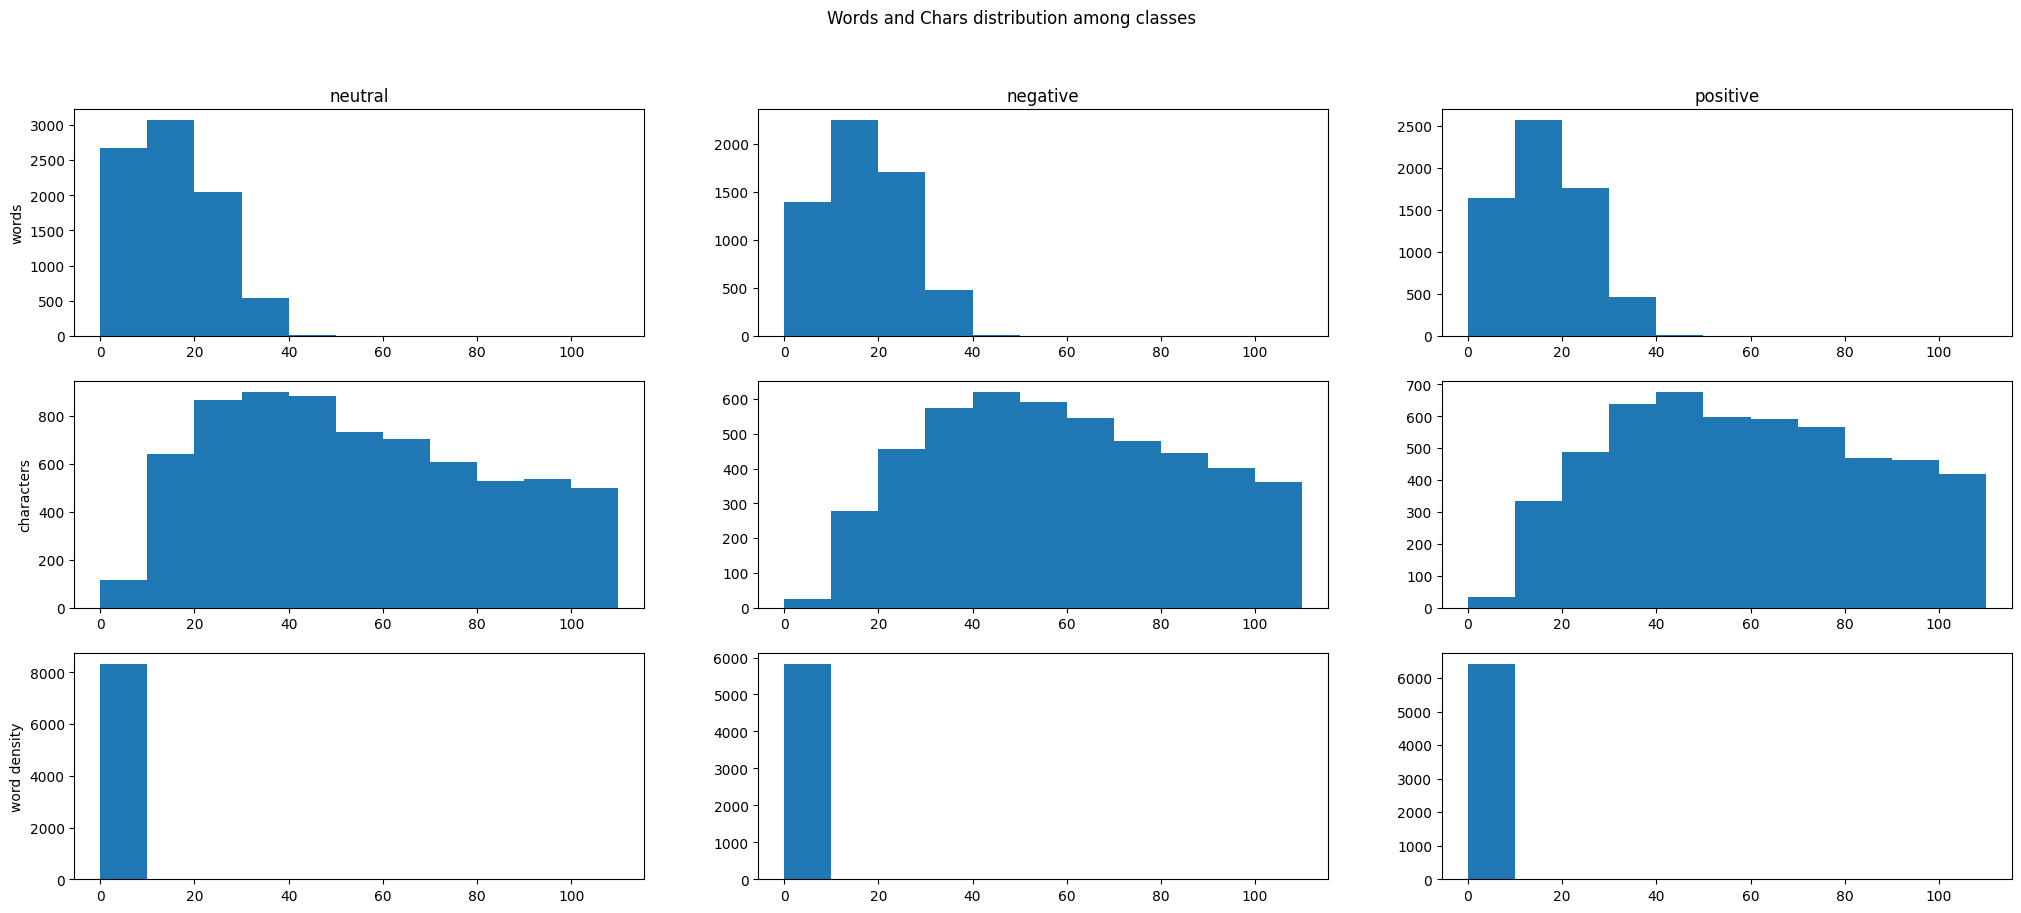

In [7]:
from nltk.tokenize import word_tokenize

text_lens = train_data['text'].apply(word_tokenize).apply(len)
text_lens_char = train_data['text'].apply(len)
word_density = text_lens / text_lens_char


print(f'Минимальная длина: {text_lens.min()} токенов, {text_lens_char.min()} символов.')
print(f'Максимальная длина: {text_lens.max()} токенов, {text_lens_char.max()} символов')

fig, axes = plt.subplots(3, 3, figsize=(25, 10))
bins = list(range(0, text_lens.max() + 10, 10))
for i, cls in enumerate(classes):
    cls_lens = text_lens[train_data['sentiment'] == cls]
    cls_lens_char = text_lens_char[train_data['sentiment'] == cls]
    cls_word_density = word_density[train_data['sentiment'] == cls]
    axes[0, i].hist(cls_lens, bins)
    axes[1, i].hist(cls_lens_char, bins)
    axes[2, i].hist(cls_word_density, bins)
    axes[0, i].set_title(cls)


axes[0, 0].set_ylabel('words')
axes[1, 0].set_ylabel('characters')
axes[2, 0].set_ylabel('word density')


plt.suptitle('Words and Chars distribution among classes')
plt.show()

Распределение по длине почти не отличается между классами. У нейтрального класса больше коротких примеров

### Использование пунктуации и капитализации и др.


Среднее использование пунктуации:
neutral: 3.37
 negative: 3.73
 positive: 3.67

Среднее использование капитализации:
neutral: 2.71
 negative: 2.71
 positive: 3.19

Среднее использование цифр:
neutral: 0.43
 negative: 0.34
 positive: 0.37

Среднее использование стоп-слов:
neutral: 22.63
 negative: 24.97
 positive: 24.45



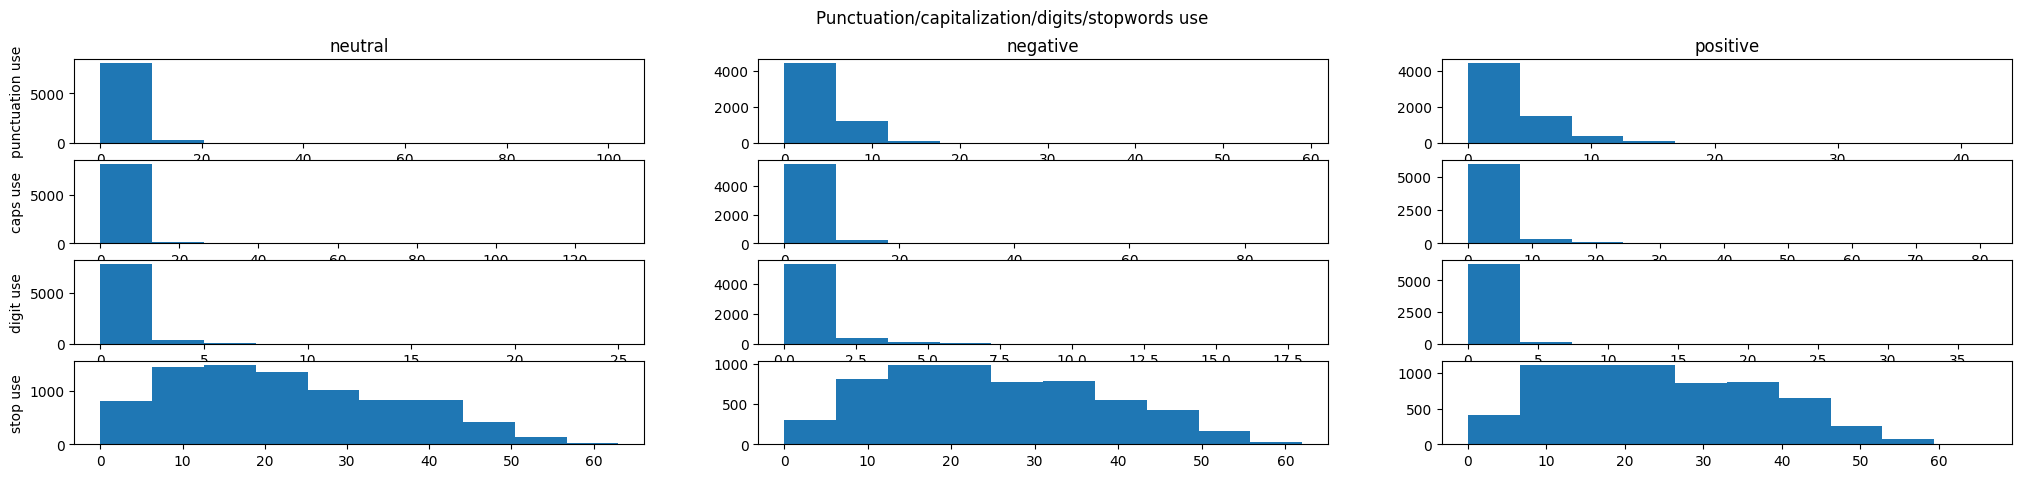

In [8]:
from string import punctuation


punct_count = train_data['text'].apply(lambda x : len([a for a in x if a in punctuation]))
caps_count = train_data['text'].apply(lambda x : len([a for a in x if a.isupper()]))
digit_count = train_data['text'].apply(lambda x : len([a for a in x if a.isdigit()]))
stop_count = train_data['text'].apply(lambda x : len([a for a in x if a in stop_words]))


print('Среднее использование пунктуации:')
print(*[f'{cls}: {punct_count[train_data["sentiment"] == cls].mean().round(2)}\n' for cls in classes])

print('Среднее использование капитализации:')
print(*[f'{cls}: {caps_count[train_data["sentiment"] == cls].mean().round(2)}\n' for cls in classes])

print('Среднее использование цифр:')
print(*[f'{cls}: {digit_count[train_data["sentiment"] == cls].mean().round(2)}\n' for cls in classes])

print('Среднее использование стоп-слов:')
print(*[f'{cls}: {stop_count[train_data["sentiment"] == cls].mean().round(2)}\n' for cls in classes])

fig, axes = plt.subplots(4, 3, figsize=(25, 5))
for i, cls in enumerate(classes):
    punct_stats = punct_count[train_data['sentiment'] == cls]
    caps_stats = caps_count[train_data['sentiment'] == cls]
    digit_stats = digit_count[train_data['sentiment'] == cls]
    stop_stats = stop_count[train_data['sentiment'] == cls]

    axes[0, i].hist(punct_stats)
    axes[1, i].hist(caps_stats)
    axes[2, i].hist(digit_stats)
    axes[3, i].hist(stop_stats)

    axes[0, i].set_title(cls)

axes[0, 0].set_ylabel('punctuation use')
axes[1, 0].set_ylabel('caps use')
axes[2, 0].set_ylabel('digit use')
axes[3, 0].set_ylabel('stop use')


plt.suptitle('Punctuation/capitalization/digits/stopwords use')
plt.show()

Здесь мы замечаем первое отличие классов: меньше всего пунктуации используется в нейтральном классе, больше всего -- в позитивном.

При этом нейтральный класс также чаще содержит меньше больших букв.

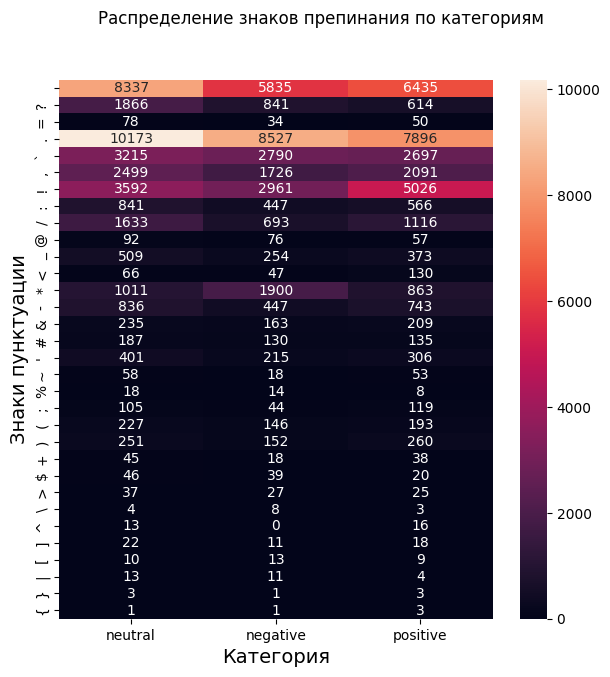

In [9]:
import seaborn as sns
from collections import Counter

marks = train_data['text'].apply(lambda x : ''.join([a for a in x if a in punctuation]))
top_marks = {
    cls : Counter(' '.join(marks[train_data['sentiment'] == cls].values))
    for cls in classes
}

marks_by_sent = pd.DataFrame(top_marks).fillna(0)
fig, axes = plt.subplots(1, 1, figsize=(7, 7), sharex=False, sharey=True)
sns.heatmap(marks_by_sent, annot=True, fmt='g')
axes.set_xlabel('Категория', fontsize=14)
axes.set_ylabel('Знаки пунктуации',  fontsize=14)
plt.suptitle('Распределение знаков препинания по категориям')
plt.show()

Видим целый ряд отличий.

Так, восклицательные знаки чаще присутствуют в позитивных текстах, точки -- в нейтральных. Знак дроби более характерен нейтральным классам, звездочки -- негативным (предположительно, для маскировки мата).

Таким образом, знаки пунктуации наряду со словами могут выступать в качестве значимого признака.

### Части речи

In [10]:
# WARNING! About 5 minutes to run

import spacy
nlp = spacy.load("en_core_web_sm")
pos = train_data['text'].apply(lambda x : [i.pos_ for i in nlp(x)])

Class neutral
Mean ratios: 0.12836524625137125 verbs, 0.15989433646375906 nouns, 0.04437449337660492 adj

Class negative
Mean ratios: 0.13619765823832886 verbs, 0.14794216582820177 nouns, 0.0626427218897487 adj

Class positive
Mean ratios: 0.1127045611902835 verbs, 0.1574475253054969 nouns, 0.07132056726172237 adj



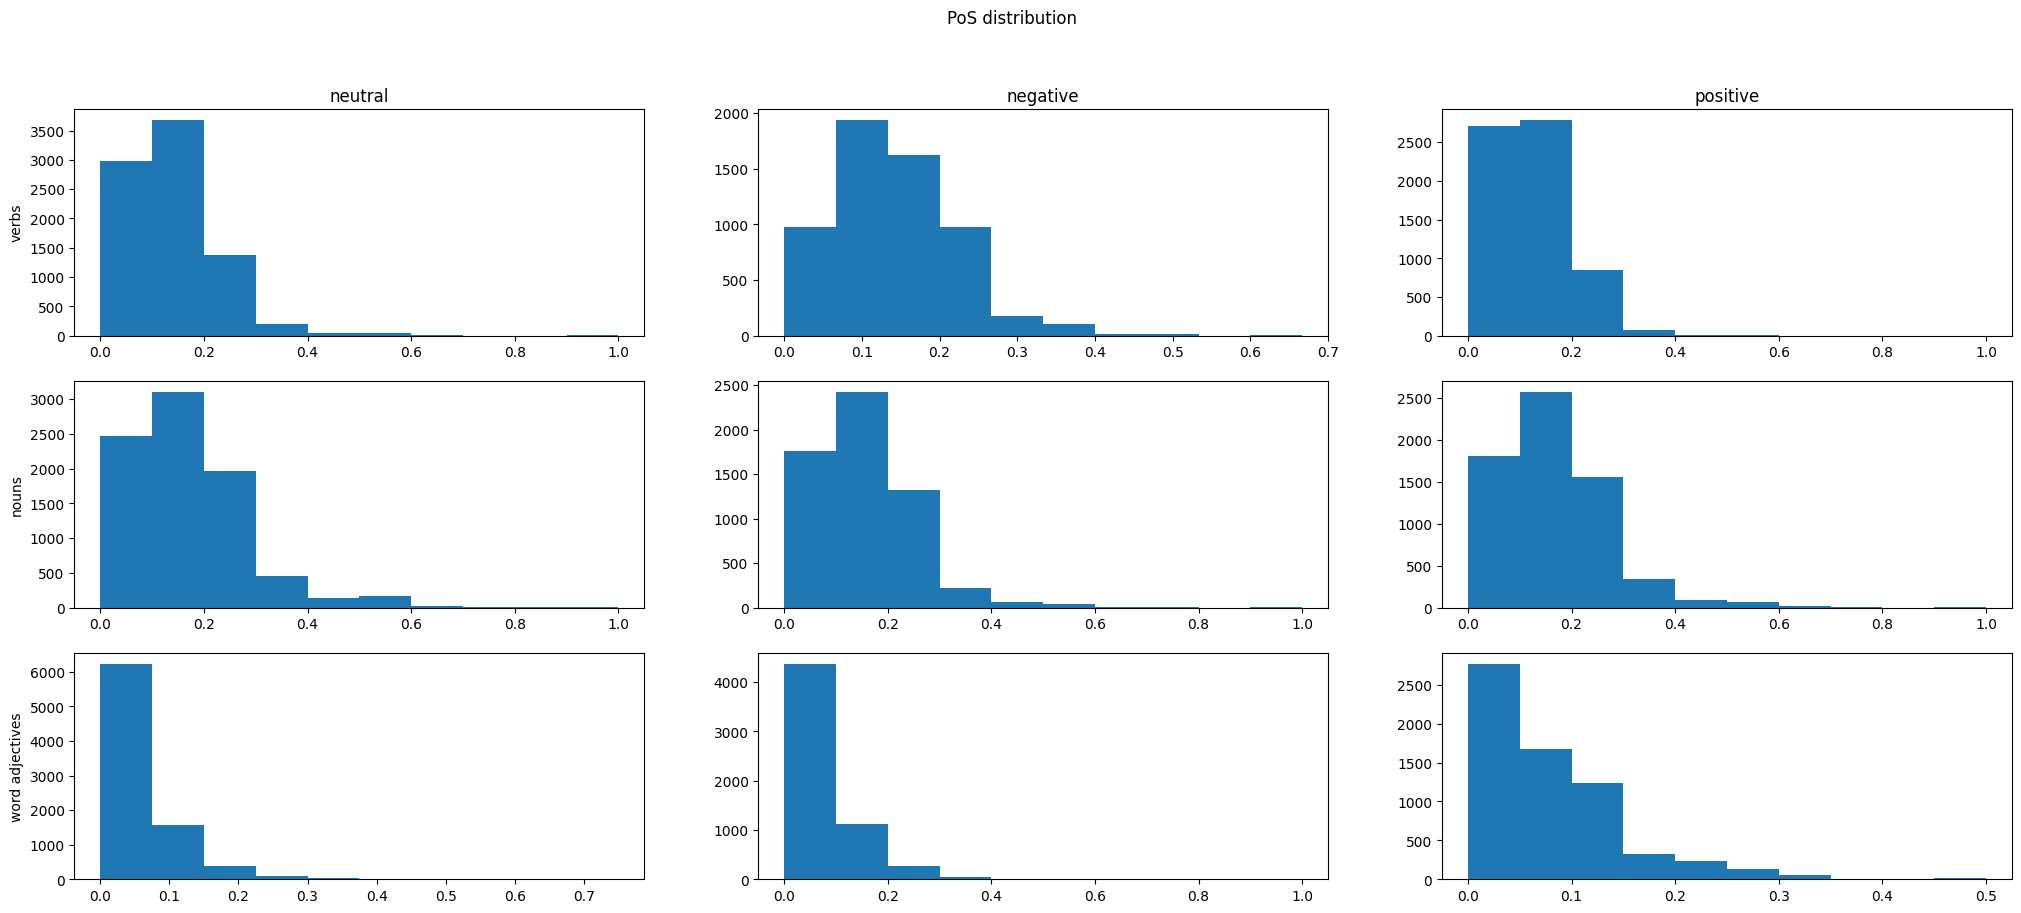

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(25, 10))
for i, cls in enumerate(classes):
    cls_pos = pos[train_data['sentiment'] == cls]
    verb_ratio = cls_pos.apply(lambda x: x.count('VERB') / len(x))
    noun_ratio = cls_pos.apply(lambda x: x.count('NOUN') / len(x))
    adj_ratio = cls_pos.apply(lambda x: x.count('ADJ') / len(x))

    print(f'Class {cls}')
    print(f'Mean ratios: {verb_ratio.mean()} verbs, {noun_ratio.mean()} nouns, {adj_ratio.mean()} adj\n')

    axes[0, i].hist(verb_ratio)
    axes[1, i].hist(noun_ratio)
    axes[2, i].hist(adj_ratio)
    axes[0, i].set_title(cls)


axes[0, 0].set_ylabel('verbs')
axes[1, 0].set_ylabel('nouns')
axes[2, 0].set_ylabel('word adjectives')

plt.suptitle('PoS distribution')
plt.show()

Можем заметить, что в классе негативной тональности наблюдается более активное использование глаголов, в классе позитивной тональности чаще встречаются прилагательные, тогда как большее количество существительных характерно нейтральному классу.

## Векторизация

###  Подготовка и очистка данных

Нормализуем данные, приведя их к начальной форме, а также удалим символы, не относящиеся к словам.

In [12]:
! pip install pymorphy3 -q


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from src.preprocessing import preprocess_data


stop_words = stopwords.words('english')
clear_train_data = preprocess_data(train_data, stop_words)
clear_test_data = preprocess_data(test_data, stop_words)
clear_train_data.head()

,text,sentiment
13544,dm amigui,neutral
2889,got wheres sun =o,neutral
23822,im bored work,negative
22031,cant wait next twitter,positive
22970,tried sleep cant bout call tisha,negative


### TF-IDF

В данном подходе вес слова для того или иного класса прямо пропорционален частоте его употребления в этом классе и обратно пропорционален частоте его употребления в остальных классах.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
train_X_tfidf = tfidf_vectorizer.fit_transform(clear_train_data['text'])
test_X_tfidf = tfidf_vectorizer.transform(clear_test_data['text'])

train_y = pd.factorize(clear_train_data['sentiment'], sort=True)[0]
test_y = pd.factorize(clear_test_data['sentiment'], sort=True)[0]

### Word2Vec

Данный подход основан на теории дистрибутивной сематике, в которой предполагается, что значение слова можно закодировать таким образом, чтобы операции над векторами могли иметь смысл.

Так, например, при вычитании вектора слова "женщина" из слова "королева" и последующем добавлении вектора слова "мужчина" может получиться вектор слова "король".

В данном случае используем Word2Vec размерности 300 обученный на Google news

In [15]:
from src.preprocessing import docs_to_vectors
import gensim
import gensim.downloader


vector_type = 'word2vec-google-news-300'
vectors_vocab = gensim.downloader.load(vector_type)

train_X_word2vec, zero_samples = docs_to_vectors(clear_train_data, vectors_vocab)
test_X_word2vec, _ = docs_to_vectors(clear_test_data, vectors_vocab)
print('Примеры посследовательностей, необработанных word2vec:')
print(*zero_samples[:5], sep='\n')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20610/20610 [00:00<00:00, 39483.26it/s]


Количество примеров, не превращённых в векторы (нулевых векторов): 144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6870/6870 [00:00<00:00, 39711.23it/s]

Количество примеров, не превращённых в векторы (нулевых векторов): 52
Примеры посследовательностей, необработанных word2vec:
['yeaaa']
['yess']
['revisingg']
['shoesshoesshoesyayyayyayloliwouldpostatwitpicbutidntknohow']
['guesss']


In [16]:
np.save('w2v_300_train.npy', train_X_word2vec)
np.save('w2v_300_test.npy', test_X_word2vec)

Как мы можем видеть, не все последовательности Word2Vec способен трансформировать в векторы. Это связано с тем, что он не может распознать некоторые жаргонные слова, не соответствующие привычным формам. Хотя количество полностью пропущенных последовательностей невелико, внутри успешно обработанных последовательностей некоторые слова также могут быть пропущены, что может являться критичным для понимания текстов, особенно, если учесть их небольшую длину.

## Классические ML алгоритмы

Рассмотрим несколько алгоритмов:

1. SVC() — Support Vector Classifier (классификатор на основе метода опорных векторов) ищет гиперплоскость, максимально разделяющую различные классы, эффективен на малых и средних наборах данных с четко разделимыми классами.

2. RidgeClassifier() — использует линейную функцию классификации с регуляризацией по L2, что помогает справляться с мультиколлинеарностью и повышает устойчивость модели к шуму в данных.

3. MultinomialNB() — это наивный байесовский классификатор, который лучше всего подходит для работы с данными, выраженными в виде частотного распределения (например, количество вхождений слов в тексте), часто используется для задач классификации текста.

4. GradientBoostingClassifier() — реализует метод градиентного бустинга деревьев решений, что позволяет последовательно улучшать точность модели за счет поэтапного снижения ошибок предыдущих базовых моделей.

5. KNeighborsClassifier() — алгоритм k-ближайших соседей классифицирует новые данные на основе большинства классов k ближайших объектов в обучающей выборке, простой и интуитивный, но может быть медленным на больших объемах данных.

In [17]:
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [18]:
from src.visualization import plot_scores, plot_roc_auc


def test_model(train_X, train_y, test_X, test_y, model):
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    print(classification_report(test_y, preds, target_names=class_names))
    return preds

### TF-IDF

In [19]:
%%time

tfidf_predictions = {}
models = [SVC(), RidgeClassifier(), MultinomialNB(), GradientBoostingClassifier(), KNeighborsClassifier()]
for clf in models:
  model_name = clf.__class__.__name__
  print(f"{model_name}:")
  tfidf_predictions[model_name] = test_model(train_X_tfidf, train_y, test_X_tfidf, test_y, clf)


SVC:
              precision    recall  f1-score   support

    negative       0.76      0.56      0.64      1945
     neutral       0.61      0.80      0.69      2779
    positive       0.80      0.67      0.73      2146

    accuracy                           0.69      6870
   macro avg       0.72      0.67      0.69      6870
weighted avg       0.71      0.69      0.69      6870

RidgeClassifier:
              precision    recall  f1-score   support

    negative       0.68      0.61      0.65      1945
     neutral       0.62      0.70      0.66      2779
    positive       0.75      0.69      0.72      2146

    accuracy                           0.67      6870
   macro avg       0.68      0.67      0.68      6870
weighted avg       0.68      0.67      0.67      6870

MultinomialNB:
              precision    recall  f1-score   support

    negative       0.73      0.46      0.56      1945
     neutral       0.54      0.78      0.64      2779
    positive       0.75      0.58     

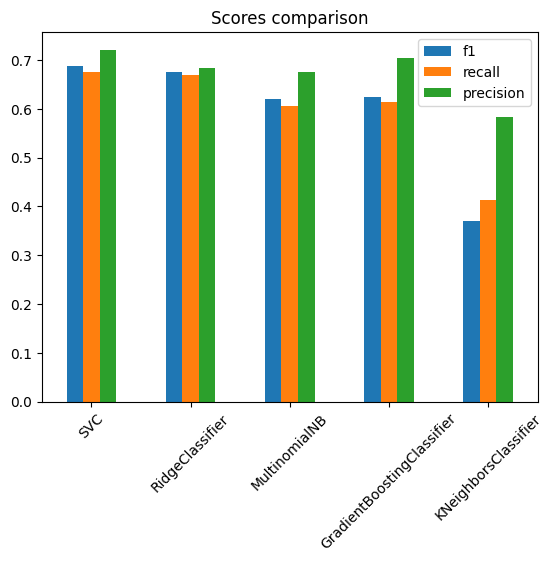

In [20]:
plot_scores(tfidf_predictions, test_y)

Дополнительно построим ROC кривые. Синяя линия показывает ROC-кривую для каждой комбинации модель-класс. ROC-кривая отображает зависимость между истинно положительной и ложно положительной характеристиками.

Черная пунктирная линия представляет случайную классификацию (AUC = 0.5). Чем сильнее синяя линия отступает от пунктирной, тем лучше.

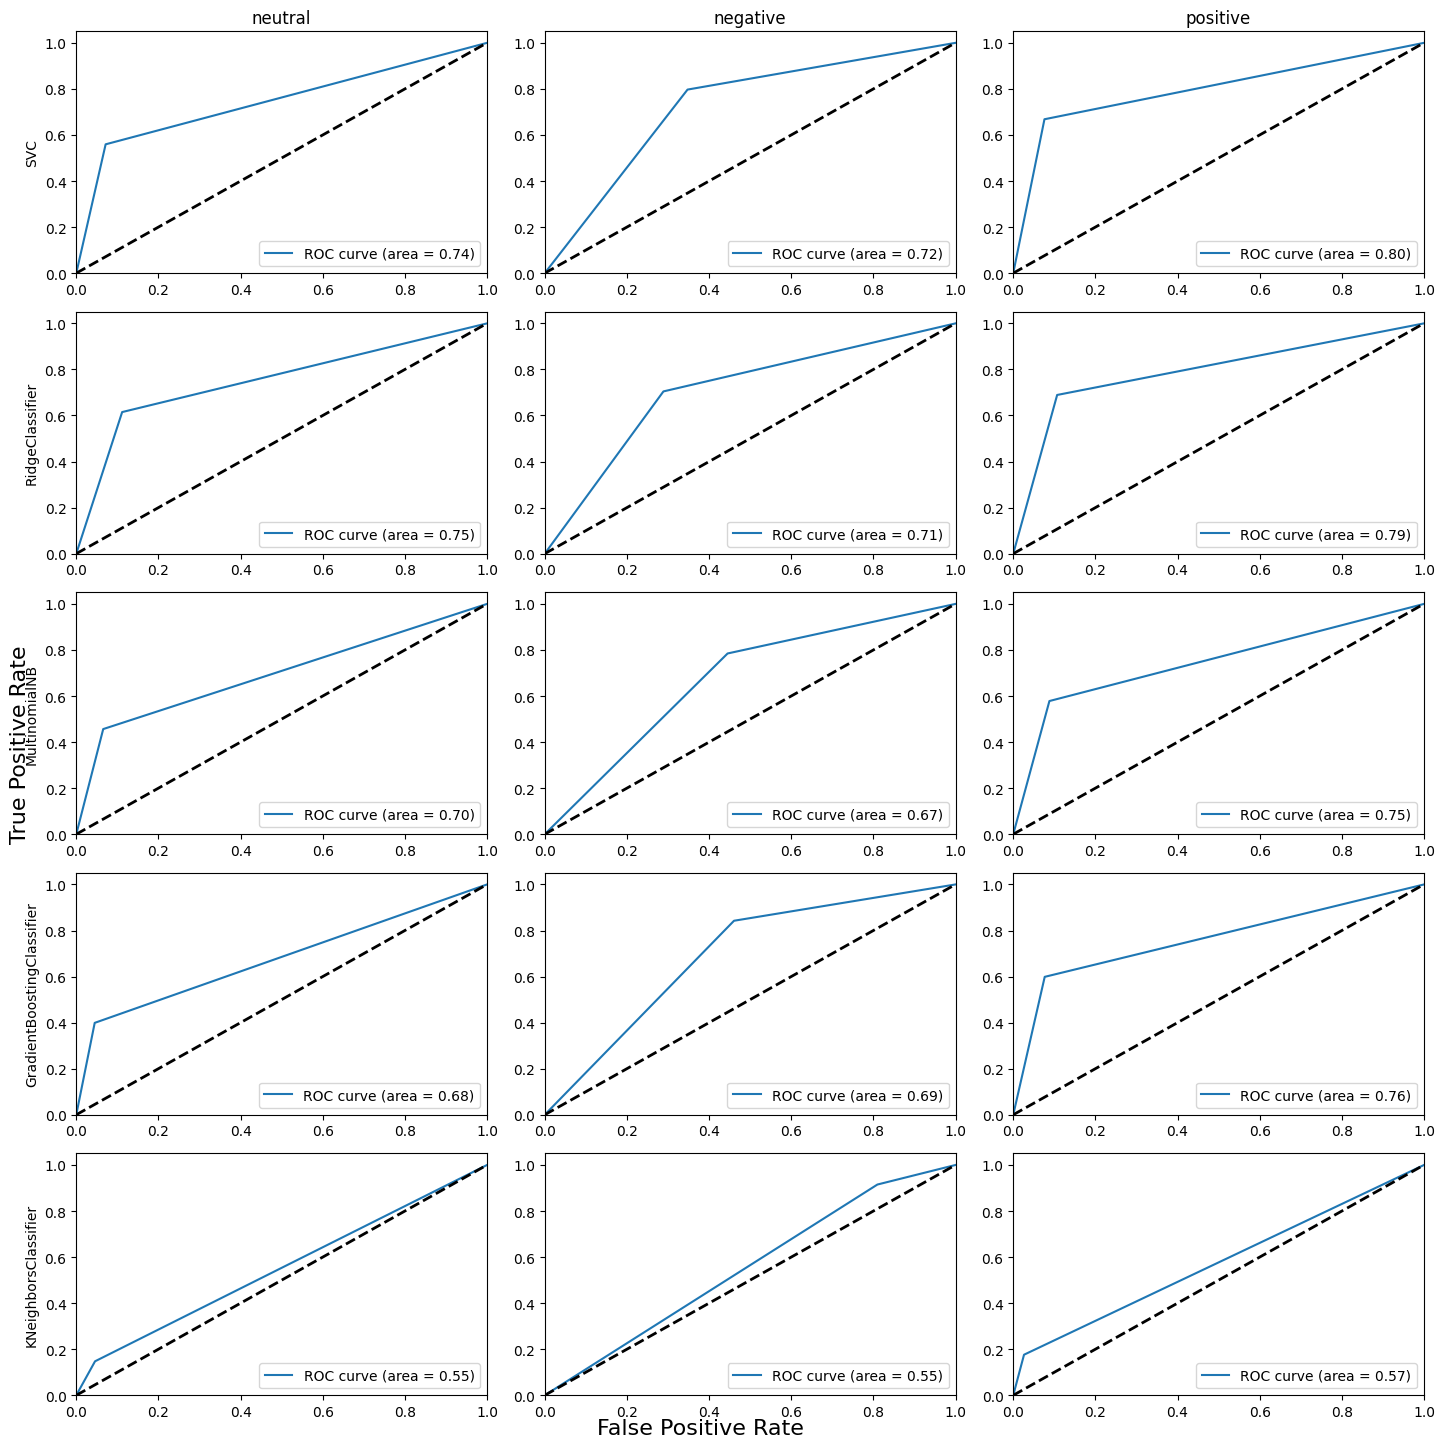

In [21]:
plot_roc_auc(tfidf_predictions, test_y)

Наиболее высоким значением AUC для нейтрального класса обладает модель RidgeClassifier (AUC = 0.75).

Позитивный класс имеет наивысшие значения AUC для всех моделей.

### Word2Vec

В случае с данной векторизацией мы откажемся от модели MultinomialNB, поскольку этот алгоритм, как следует из названия, предполагает мультиномиальное распределение -- обощение биномиального. Иными словами, ожидается, что значения не могут быть отрицательными, тогда как векторизация Word2Vec, в отличие от TF-IDF, этого не гарантирует.

In [22]:
%%time

word2vec_predictions = {}
models = [SVC(), RidgeClassifier(), KNeighborsClassifier(5)]
for model in models:
  model_name = model.__class__.__name__
  print(f"{model_name}:")
  word2vec_predictions[model_name] = test_model(train_X_word2vec, train_y, test_X_word2vec, test_y, model)


SVC:
              precision    recall  f1-score   support

    negative       0.72      0.65      0.68      1945
     neutral       0.65      0.74      0.69      2779
    positive       0.77      0.70      0.73      2146

    accuracy                           0.70      6870
   macro avg       0.71      0.69      0.70      6870
weighted avg       0.71      0.70      0.70      6870

RidgeClassifier:
              precision    recall  f1-score   support

    negative       0.70      0.64      0.67      1945
     neutral       0.64      0.72      0.68      2779
    positive       0.74      0.68      0.71      2146

    accuracy                           0.69      6870
   macro avg       0.70      0.68      0.69      6870
weighted avg       0.69      0.69      0.69      6870

KNeighborsClassifier:
              precision    recall  f1-score   support

    negative       0.54      0.59      0.56      1945
     neutral       0.56      0.56      0.56      2779
    positive       0.66      0.

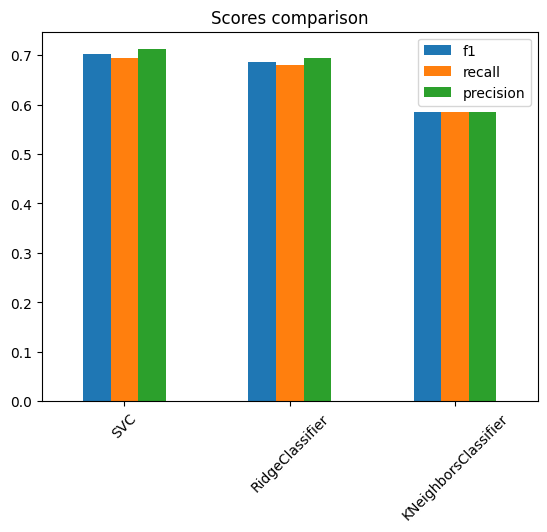

In [23]:
plot_scores(word2vec_predictions, test_y)

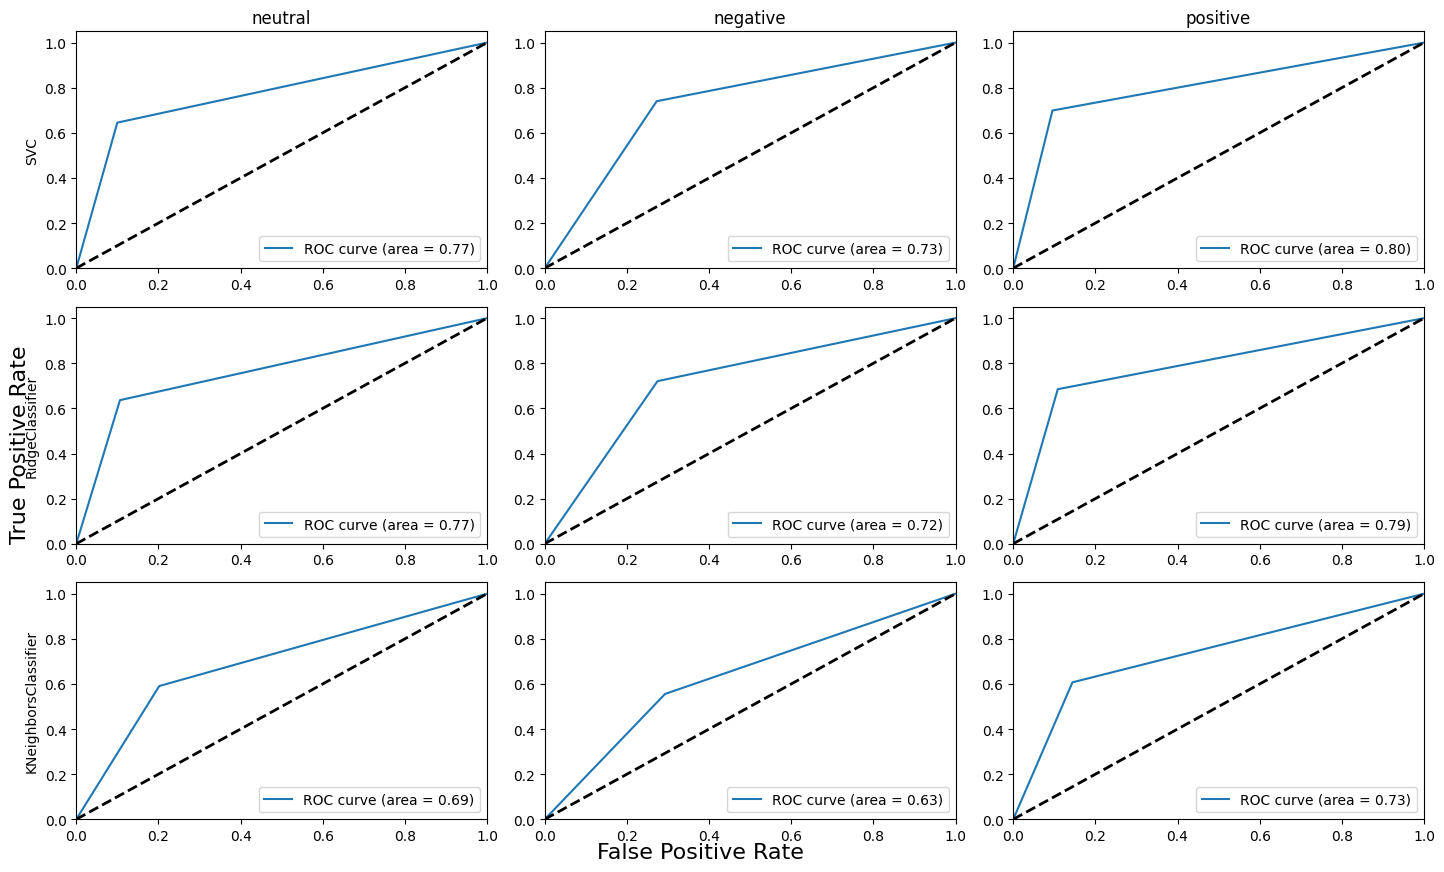

In [24]:
plot_roc_auc(word2vec_predictions, test_y)

Как и в случае с TF-IDF, нейтральный класс имеет много False Positive примеров. По сравнению с предыдущим методом векторизации, f1 по разным классам распределён более равномерно. KNN снова показал худший результат.

Попробуем визуализировать результаты векторизации данных методом Word2Vec путём понижения размерности векторов методом PCA.

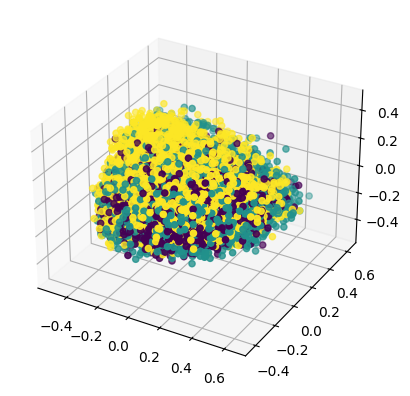

In [25]:
from sklearn.decomposition import PCA


pca = PCA(3)

data_3d = pca.fit_transform(train_X_word2vec)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*np.split(data_3d, 3, axis=1), c=train_y)
None

Судя по всему Word2Vec плохо подходит для разделения классов, что объясняет посредственные результаты работы алгоритмов.

## Нейронные сети
### Попробуем применить 2 архитектуры нейронных сетей, способных работать с последовательностями - сеть с одномерными свёртками и LSTM.

In [26]:
import torch
import torch.nn as nn
from torch.optim.adamw import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader

from src.nns import MyCNN, MyLSTM, VectorDataset, data_collator, train


torch.manual_seed(42)

In [27]:
train_dataset, val_dataset = VectorDataset(clear_train_data['text'].values, train_y, vectors_vocab), VectorDataset(clear_test_data['text'].values, test_y, vectors_vocab)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
num_steps = len(train_dataloader) * epochs
lr = 2e-3
weight_decay = 0.05
min_lr = 1e-7

### CNN

In [29]:
model = MyCNN(300, 96, 3).to(device)

optim = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = CosineAnnealingLR(optim, num_steps, min_lr)

train(model, epochs, optim, 'cnn', train_dataloader, val_dataloader, class_names, scheduler, device)

Training: 645it [00:07, 91.28it/s] 
Validation: 215it [00:01, 123.35it/s]


NameError: name 'test_y' is not defined

Природа ошибок CNN отличается от предыдущих экспериментов с классическими ML-моделями. Нейтральный класс не имеет сильного проседания по precision, он теперь даже выше, чем recall. Recall других классов также возрос, что говорит о прогрессе в проблеме отделения negative класса от нейтрального.

### LSTM

In [ ]:
model = MyLSTM(300, 96, 3).to(device)

optim = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = CosineAnnealingLR(optim, num_steps, min_lr)

train(model, epochs, optim, 'lstm', train_dataloader, val_dataloader, class_names, scheduler, device)

Позитивный класс определяется лучше всего. В отличии от CNN, негативный класс снова чаще определяется как какой-то другой.

### Попробуем тренировать нейронные сети без удаления стоп-слов и чистки от мусора, как это делается для современных больших языковых моделей.

In [ ]:
train_dataset = VectorDataset(preprocess_data(train_data, clean=False)['text'].values, train_y, vectors_vocab)
val_dataset =  VectorDataset(preprocess_data(test_data, clean=False)['text'].values, test_y, vectors_vocab)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

### CNN

In [ ]:
model = MyCNN(300, 96, 3).to(device)

epochs = 10
optim = AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

num_steps = len(train_dataloader) * epochs
scheduler = CosineAnnealingLR(optim, num_steps, 1e-7)

train(model, epochs, optim, 'cnn', train_dataloader, val_dataloader, class_names, scheduler, device)

### LSTM

In [ ]:
model = MyLSTM(300, 96, 3).to(device)

epochs = 10
optim = AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

num_steps = len(train_dataloader) * epochs
scheduler = CosineAnnealingLR(optim, num_steps, 1e-7)

train(model, epochs, optim, 'lstm', train_dataloader, val_dataloader, class_names, scheduler, device)

Без удаления стоп-слов и прочей очистки данных, результаты существенно улучшились. Так как задача состоит в предсказании настроения, стоп-слова, их количество, всякого рода отрицания могут многое сказать о тональности текста. Как было выявлено на этапе EDA, пунктуация и спец. символы также имеет разное распределение между классами.

### Вывод по нейронным сетям
Поскольку для обоих моделей при уменьшении тренировочного лосса уменьшается также и валидационная метрика, можно с уверенностью сказать о таком явлении как переобучение. Возможно, дело в слишком большом количестве обучаемых параметров сетей. Или же, использование в качестве входных ембеддингов векторов из Word2Vec является не лучшим способом представления данных из-за пропуска некоторых слов. Результаты без жесткой обработки текста сильно лучше, чем результаты с обработкой, что по нашему мнению обусловлено спецификой задачи.